### Pytorch Helmet detection using Faster RCNN Transfer learning

Segregating dataset into train & validation (total 5000 images: train:3500, val:1000, test 500)

In [1]:
# storing file paths
file_path = '../input/hard-hat-detection/'
ann_path = file_path + 'annotations/'
img_path = file_path + 'images/'

In [2]:
# segregate the dataset into train & validation (there are 5000 images)(train:3500, val:1000, tes:500)

from pathlib import Path

path_annotations = []
for i in Path(ann_path).glob('*.xml'):
    path_annotations.append(i)
path_annotations = sorted(path_annotations) #contains path to 5000 annots

path_images = []
for i in Path(img_path).glob('*.png'):
    path_images.append(i)
path_images = sorted(path_images) #contains path to 5000 images

In [3]:
# Split data : 70% Train, 20% Val, 10% Tes
path_train_annot = path_annotations[:3500]
path_train_images = path_images[:3500]

path_val_annot = path_annotations[3500:4500]
path_val_images = path_images[3500:4500]

path_tes_annot = path_annotations[4500:5000]
path_tes_images = path_images[4500:5000]

In [4]:
# making dirs to segregate train & val images & annotations & also to save best trained model
import os

# Creating directories to put train & val data
os.makedirs('./train/annotations',exist_ok = True)
os.makedirs('./train/images', exist_ok = True)
os.makedirs('./val/annotations', exist_ok = True)
os.makedirs('./val/images', exist_ok = True)
os.makedirs('./tes/annotations', exist_ok = True)
os.makedirs('./tes/images', exist_ok = True)
os.makedirs('./savedmodel', exist_ok = True)

In [5]:
# copying images & xml annotations from input to working folder
import shutil
from tqdm import tqdm

for i, (path_annot, path_img) in tqdm(enumerate(zip(path_train_annot, path_train_images))):
    shutil.copy(path_img, './train/images/' + path_img.parts[-1])
    shutil.copy(path_annot, './train/annotations/' + path_annot.parts[-1])
    
for i, (path_annot, path_img) in tqdm(enumerate(zip(path_val_annot, path_val_images))):
    shutil.copy(path_img, './val/images/' + path_img.parts[-1])
    shutil.copy(path_annot, './val/annotations/' + path_annot.parts[-1])

for i, (path_annot, path_img) in tqdm(enumerate(zip(path_tes_annot, path_tes_images))):
    shutil.copy(path_img, './tes/images/' + path_img.parts[-1])
    shutil.copy(path_annot, './tes/annotations/' + path_annot.parts[-1])
# cpu 2min

3500it [00:50, 69.74it/s]
1000it [00:13, 73.08it/s]
500it [00:06, 76.75it/s]


In [ ]:
import os
path = "/kaggle/working/tes/images"
fileList=os.listdir(path)
print(fileList)
print(len(fileList))
# for checking whether file is not a directory
print(len([fname for fname in os.listdir(path) if os.path.isfile(os.path.join(path, fname))]))

In [ ]:
import os
path = "/kaggle/working/val/images"
fileList=os.listdir(path)
print(fileList)
print(len(fileList))
# for checking whether file is not a directory
print(len([fname for fname in os.listdir(path) if os.path.isfile(os.path.join(path, fname))]))

Initialization & Image Transformations

In [8]:
import torch

BATCH_SIZE = 8 #increase / decrease according to memeory
NUM_EPOCHS = 10 # number of epochs to train for
NUM_WORKERS = 2
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# training images and XML files directory
TRAIN_DIR = './train'
# validation images and XML files directory
VALID_DIR = './val'
# test images and XML files directory
TEST_DIR = './tes'


# classes: 0 index is reserved for background
CLASS_NAME = ['__background__', 'helmet', 'head', 'person']
NUM_CLASSES = len(CLASS_NAME)

In [9]:
# Apply transform to image
import albumentations as A #new method, customizable transformations
from albumentations.pytorch import ToTensorV2

# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
        ], bbox_params={'format': 'pascal_voc','label_fields': ['labels']}
    )

# define the validation transforms (validation data shud not be augmented)
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )

# The collate_fn() will help us take care of tensors of varying sizes while creating
# the training and validation data loaders.
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

Prepare Pytorch Dataset

In [10]:
# Prepare the pytorch dataset

from torch.utils.data import Dataset, DataLoader
import glob, matplotlib.pyplot as plt, matplotlib.patches as patches
import xml.etree.ElementTree as ET


# foll is the class to create pytorch dataset from images(.png) & annotations(.xml)
class SafetyHelmDataset(Dataset):
    def __init__(self, dir_path, class_name, transforms=None):
        self.dir_path = dir_path
        self.class_name = class_name
        self.transforms = transforms
        
        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/images/*.png")
        self.all_images = sorted(self.image_paths)
        
        
    def __getitem__(self, idx: int):
        image_name = self.all_images[idx] #reading image one by one
        
        image = plt.imread(image_name) #read the image
        image /= 255.0 #normalize pixels b/w 0 & 1
        
        # capture the corresponding xml file for getting annotations
        annot_filepath = os.path.join(f'{self.dir_path}/annotations/', Path(image_name).parts[-1][:-4] + '.xml')
        
        boxes, labels = [], []
        root = ET.parse(annot_filepath).getroot() #reading xml file
        
        # extracting box coordinates from xml annotations
        for member in root.findall('object'):
            # map the current object name to classes to get the label index
            labels.append(self.class_name.index(member.find('name').text))
            
            # (xmin, ymin) are left corner coordinates & (xmax, ymax) are right corner coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            boxes.append([xmin, ymin, xmax, ymax])
        
        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # prepare the final target dict
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        image_id = torch.tensor([idx])
        target['image_id'] = image_id
        
        # apply image transforms
        if self.transforms:
            sample = self.transforms(image=image, bboxes=target['boxes'], labels=labels)
            image = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return image, target #these are the o/p of this class
        
        
    def __len__(self):
        return len(self.all_images)


In [11]:
# creating object of the class SafetyHelmetDataset which takes images & annotations folder,
# class_name & transformations as arguments & o/p image & bounding box coordinates &
# corresponding class_names

train_dataset = SafetyHelmDataset(TRAIN_DIR, CLASS_NAME, get_train_transform())
valid_dataset = SafetyHelmDataset(VALID_DIR, CLASS_NAME, get_valid_transform())

train_loader = DataLoader( #for loading data in batches, pytorch requires image as channel 1st e.g (3(channel),640(ht),480(wd))
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

len(train_dataset), len(valid_dataset)

(3500, 1000)

Visualizing transformed samples from train dataset

In [12]:
# functions to display samples a/w bounding box
import numpy as np, scipy

def img_show(img, ax = None, figsize=(16,8)): #function to show image
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    ax.xaxis.tick_top()
    ax.imshow(img)
    return ax
        
def draw_box(img, ax, bb, lbl): #func to draw bounding box
    if lbl=='helmet':
        color_lbl='red'
    elif lbl=='head':
        color_lbl='yellow'
    else:
        color_lbl='blue'
    
    # rectangle draws bbox around the class
    rect = patches.Rectangle(
        (int(bb[0]),int(bb[1])), int(bb[2])-int(bb[0]), int(bb[3])-int(bb[1]),
        fill=False, edgecolor=color_lbl, lw=2
    )
    ax.add_patch(rect)


def plot_sample(a_img, tgt, ax=None, figsize=(16,8)):
    img = np.array(a_img).copy() #making deep copy for reproducibility (else if run 2nd time it gives err)
    img = img*255 #multiplying with 255 becoz in augmtn pixels r normalized
    img = np.transpose(img, (2,1,0)) #making channel 1st to channel last (i.e from (3,416,416) to (416,416,3))
    tr_img = scipy.ndimage.rotate(img, 270, reshape=False) #rotatg becoz rcvd img was hztlly left faced
    tr_img = np.flip(tr_img, axis=1) #mirroring the image becoz rcvd img was flipped
    ax = img_show(tr_img, ax=ax)
    
    for box_id in range(len(tgt['boxes'])):
        box = tgt['boxes'][box_id] #target['boxes'][box_id] contains (xmin, ymin, xmax, ymax) i.e bbox coor for each label
        lbl = CLASS_NAME[tgt['labels'][box_id]] #converting index back to str labels i.e 1 to 'helmet'
        draw_box(tr_img, ax, box, lbl) #drawing multiple bbox on single image using matplotlib

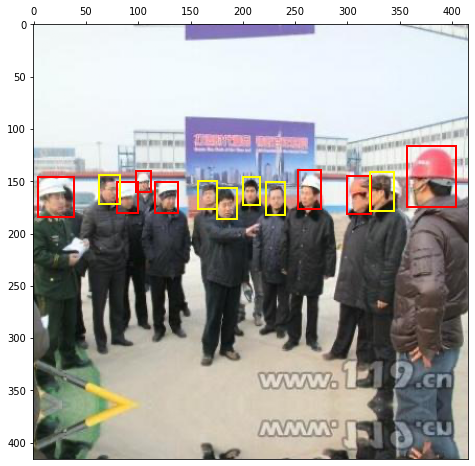

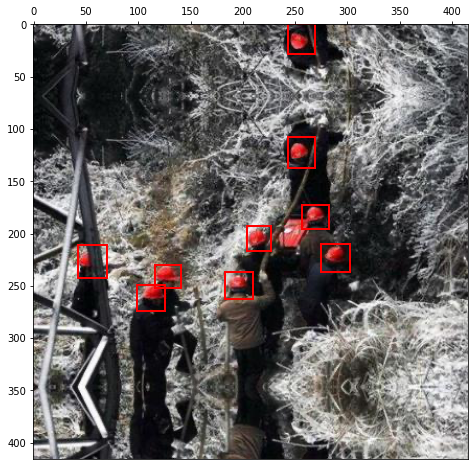

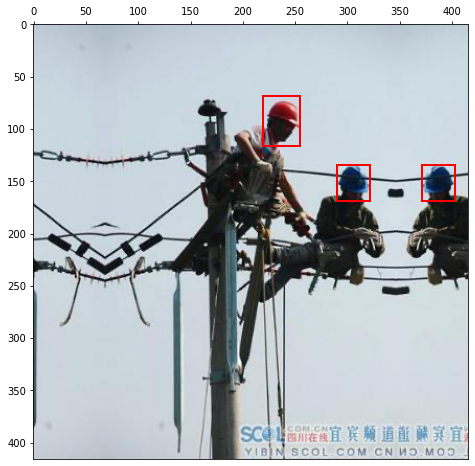

In [13]:
# red=helmet, yellow=head
for i in range(3):
    a_img, trgt = train_dataset[i] #extracting image info from albumentated train dataset
    plot_sample(a_img, trgt) #a_img & trgt are float arrays

### Faster RCNN Model with ResNet50 Backbone

In [14]:
# creating customised FasterRCNN model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

In [15]:
# initialize the model and move to the computation device GPU
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)

# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]

# define the optimizer
# (this is the simple optimizer you can use other optimizer with callbacks for complex dataset)
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [16]:
# The training function always returns a list containing the training loss values
# for all the completed iterations

# function for running training iterations
def train(train_data_loader, model):
    print('Training...')
    global train_itr
    global train_loss_list
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [17]:
# The validation function returns a similar list containing the loss values
# for all the completed iterations

# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating...')
    global val_itr
    global val_loss_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [18]:
# this class keeps track of the training and validation loss values
# and helps to get the average for each epoch as well
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [19]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(self, best_valid_loss=float('inf')):
        self.best_valid_loss = best_valid_loss
        
    def __call__(self, current_valid_loss, epoch, model, optimizer):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss:.3f}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, './savedmodel/best_model.pth')


# function to save the model after each epoch and after training ends
def save_model(epoch, model, optimizer):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, './savedmodel/last_model.pth')

### Training of Faster RCNN on custom dataset begins here

In [20]:
# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1

# train and validation loss lists to store loss values of all
# iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []

# initialize SaveBestModel class
save_best_model = SaveBestModel()

# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
    
    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()
    
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")   
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")   
    
    # save the best model till now if we have the least loss in the current epoch
    save_best_model(val_loss_hist.value, epoch, model, optimizer)
    # save the current epoch model
    save_model(epoch, model, optimizer)



EPOCH 1 of 10
Training...


Loss: 0.5109: 100%|██████████| 438/438 [06:12<00:00,  1.18it/s]


Validating...


Loss: 0.6153: 100%|██████████| 125/125 [00:51<00:00,  2.41it/s]


Epoch #1 train loss: 0.645
Epoch #1 validation loss: 0.623

Best validation loss: 0.623

Saving best model for epoch: 1


EPOCH 2 of 10
Training...


Loss: 0.4852: 100%|██████████| 438/438 [06:06<00:00,  1.19it/s]


Validating...


Loss: 0.4556: 100%|██████████| 125/125 [00:52<00:00,  2.39it/s]


Epoch #2 train loss: 0.551
Epoch #2 validation loss: 0.520

Best validation loss: 0.520

Saving best model for epoch: 2


EPOCH 3 of 10
Training...


Loss: 0.3845: 100%|██████████| 438/438 [06:06<00:00,  1.19it/s]


Validating...


Loss: 0.3993: 100%|██████████| 125/125 [00:52<00:00,  2.38it/s]


Epoch #3 train loss: 0.490
Epoch #3 validation loss: 0.502

Best validation loss: 0.502

Saving best model for epoch: 3


EPOCH 4 of 10
Training...


Loss: 0.6236: 100%|██████████| 438/438 [06:07<00:00,  1.19it/s]


Validating...


Loss: 0.3416: 100%|██████████| 125/125 [00:52<00:00,  2.39it/s]


Epoch #4 train loss: 0.450
Epoch #4 validation loss: 0.456

Best validation loss: 0.456

Saving best model for epoch: 4


EPOCH 5 of 10
Training...


Loss: 0.4414: 100%|██████████| 438/438 [06:07<00:00,  1.19it/s]


Validating...


Loss: 0.3359: 100%|██████████| 125/125 [00:52<00:00,  2.38it/s]


Epoch #5 train loss: 0.422
Epoch #5 validation loss: 0.443

Best validation loss: 0.443

Saving best model for epoch: 5


EPOCH 6 of 10
Training...


Loss: 0.3700: 100%|██████████| 438/438 [06:07<00:00,  1.19it/s]


Validating...


Loss: 0.3632: 100%|██████████| 125/125 [00:52<00:00,  2.40it/s]


Epoch #6 train loss: 0.405
Epoch #6 validation loss: 0.432

Best validation loss: 0.432

Saving best model for epoch: 6


EPOCH 7 of 10
Training...


Loss: 0.3183: 100%|██████████| 438/438 [06:07<00:00,  1.19it/s]


Validating...


Loss: 0.3261: 100%|██████████| 125/125 [00:52<00:00,  2.37it/s]


Epoch #7 train loss: 0.391
Epoch #7 validation loss: 0.427

Best validation loss: 0.427

Saving best model for epoch: 7


EPOCH 8 of 10
Training...


Loss: 0.5597: 100%|██████████| 438/438 [06:07<00:00,  1.19it/s]


Validating...


Loss: 0.3418: 100%|██████████| 125/125 [00:52<00:00,  2.39it/s]


Epoch #8 train loss: 0.380
Epoch #8 validation loss: 0.424

Best validation loss: 0.424

Saving best model for epoch: 8


EPOCH 9 of 10
Training...


Loss: 0.4001: 100%|██████████| 438/438 [06:07<00:00,  1.19it/s]


Validating...


Loss: 0.3212: 100%|██████████| 125/125 [00:52<00:00,  2.39it/s]


Epoch #9 train loss: 0.366
Epoch #9 validation loss: 0.413

Best validation loss: 0.413

Saving best model for epoch: 9


EPOCH 10 of 10
Training...


Loss: 0.2560: 100%|██████████| 438/438 [06:07<00:00,  1.19it/s]


Validating...


Loss: 0.3209: 100%|██████████| 125/125 [00:52<00:00,  2.39it/s]


Epoch #10 train loss: 0.355
Epoch #10 validation loss: 0.415


### Evaluating the model

In [21]:
# We will not need the XML files, as the images are just enough to get the predictions by
# doing a forward pass through the trained model

# load the best model and trained weights
model = create_model(num_classes=NUM_CLASSES)
checkpoint = torch.load('./savedmodel/best_model.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

# any detection having score below this will be discarded, i.e bbox with scores more than 0.8
# will be shown, less than the threshold will not be shown
detection_threshold = 0.8

In [22]:
# function to get actual bounding boxes & labels for the given image, which takes image_path
# & returns bbox coordinates & labels/class_names
def get_box_lbl(img_path):
    annot_filepath = os.path.join('./tes/annotations/', Path(img_path).parts[-1][:-4] + '.xml')
    
    boxes, labels = [], []
    root = ET.parse(annot_filepath).getroot()

    # extracting box coordinates from xml annotations
    for member in root.findall('object'):
        # map the current object name to classes to get the label index
        labels.append(CLASS_NAME.index(member.find('name').text))

        # (xmin, ymin) are left corner coordinates & (xmax, ymax) are right corner coordinates
        xmin = int(member.find('bndbox').find('xmin').text)
        ymin = int(member.find('bndbox').find('ymin').text)
        xmax = int(member.find('bndbox').find('xmax').text)
        ymax = int(member.find('bndbox').find('ymax').text)

        boxes.append([xmin, ymin, xmax, ymax])
    
    return boxes, labels

In [23]:
# foll are various func to draw predicted bounding boxes & labels
import matplotlib.patches as patches, numpy as np

def img_show(img, ax = None, figsize=(16,8)):
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    ax.xaxis.tick_top()
    ax.imshow(img)
    return ax

def draw_box(ax, bb, lbl):
    if lbl=='helmet': # 1=helmet
        color_lbl='red'
    elif lbl=='head': # 2=head
        color_lbl='yellow'
    else:
        color_lbl='blue'
    
    rect = patches.Rectangle(
        (int(bb[0]),int(bb[1])), int(bb[2])-int(bb[0]), int(bb[3])-int(bb[1]),
        fill=False, edgecolor=color_lbl, lw=2
    )
    ax.add_patch(rect)
    

def plot_pred(ax, tboxes, tlbls):
    for i in range(len(tboxes)):
        draw_box(ax, tboxes[i], tlbls[i])

def plot_act(img, boxes, ax=None, figsize=(16,8)):
    ax = img_show(img, ax=ax)
    for i in range(len(boxes)):
        rect = patches.Rectangle(
            (int(boxes[i][0]),int(boxes[i][1])), int(boxes[i][2])-int(boxes[i][0]), int(boxes[i][3])-int(boxes[i][1]),
            fill=False, edgecolor='green', lw=2
            )
        ax.add_patch(rect)
    return ax

In [25]:
# function to get actual bounding boxes & labels for the given image, which takes image_path
# & returns bbox coordinates & labels/class_names
def get_box_lbl(img_path):
    annot_filepath = os.path.join('./tes/annotations/', Path(img_path).parts[-1][:-4] + '.xml')
    
    boxes, labels = [], []
    root = ET.parse(annot_filepath).getroot()

    # extracting box coordinates from xml annotations
    for member in root.findall('object'):
        # map the current object name to classes to get the label index
        labels.append(CLASS_NAME.index(member.find('name').text))

        # (xmin, ymin) are left corner coordinates & (xmax, ymax) are right corner coordinates
        xmin = int(member.find('bndbox').find('xmin').text)
        ymin = int(member.find('bndbox').find('ymin').text)
        xmax = int(member.find('bndbox').find('xmax').text)
        ymax = int(member.find('bndbox').find('ymax').text)

        boxes.append([xmin, ymin, xmax, ymax])
    
    return boxes, labels

Green are the actual boxes, red & blue boxes are predicted by Faster RCNN model.


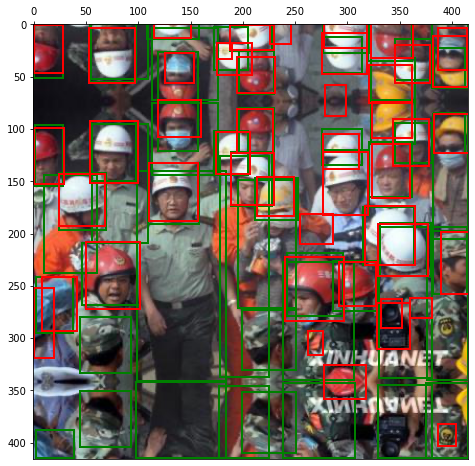

In [28]:
a = '/kaggle/working/tes/images/hard_hat_workers857.png'
image = plt.imread(a)
img = image.copy()

# bring color channels to front
img = np.transpose(img, (2, 0, 1)).astype(np.float32)

# convert to tensor; tensor([  3., 416., 416.], device='cuda:0')
img = torch.tensor(img, dtype=torch.float).cuda() #gpu enabled
    
# add batch dimension
img = torch.unsqueeze(img, 0)
with torch.no_grad(): #forward pass
    outputs = model(img.to(DEVICE))

# load all detection to CPU for further operations
outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

# draw actual bounding boxes (to compare with predicted boxes)
act_box, act_lbl = get_box_lbl(a) #get actual boxes & labels
ax = plot_act(image, act_box)

# carry further only if there are detected boxes
if len(outputs[0]['boxes']) > 0:
    boxes = outputs[0]['boxes'].data.numpy() #converting tensor coordinates to numpy array
    scores = outputs[0]['scores'].data.numpy()
    lbls = outputs[0]['labels'].data.numpy()

    # filter out boxes according to `detection_threshold`
    boxes = boxes[scores > detection_threshold].astype(np.int32)
    lbls = lbls[scores > detection_threshold].astype(np.int32)
    pred_boxes = boxes.copy()

    # get all the predicited class names
    pred_class = [CLASS_NAME[i] for i in lbls]

    # draw predicted boxes (to compare with actuals)
    plot_pred(ax, pred_boxes, pred_class)
print("Green are the actual boxes, red & blue boxes are predicted by Faster RCNN model.")